# Hitting Time Stats (Daily Data)

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# Define the ticker symbols
equity_tickers = ["SPY", "QQQ", "NVDA"]
crypto_tickers = ["BTC-USD", "SOL-USD"]

tickers = equity_tickers + crypto_tickers

In [57]:
# Specify the period and interval
index_data = yf.download(equity_tickers, interval="1d", group_by='ticker')
crypto_data = yf.download(crypto_tickers, interval="1d", group_by='ticker')

# Combine all data into a single DataFrame
data = pd.concat([index_data, crypto_data], axis=1)
# Extract the 'Close' data for each ticker
close_data = data.xs('Close', level=1, axis=1)
close_data.dropna(inplace=True)

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  2 of 2 completed
/var/folders/fb/bhld2vy11kjg5bh1hpblh9fm0000gn/T/ipykernel_67247/954340622.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_data.dropna(inplace=True)


In [58]:
close_data

Ticker,QQQ,SPY,NVDA,SOL-USD,BTC-USD
Date,,,,,
2020-04-13,203.029999,275.660004,6.746250,0.777832,6845.037598
2020-04-14,211.860001,283.790009,7.098750,0.661925,6842.427734
2020-04-15,209.429993,277.760010,7.021000,0.646651,6642.109863
2020-04-16,213.250000,279.100006,7.367500,0.690816,7116.804199
2020-04-17,215.289993,286.640015,7.308000,0.660728,7096.184570
...,...,...,...,...,...
2024-09-18,471.440002,561.400024,113.370003,133.991852,61649.679688
2024-09-19,483.359985,570.979980,117.870003,142.836273,62940.457031
2024-09-20,482.440002,568.250000,116.000000,146.566803,63192.976562


In [59]:
# Define 1% as alpha
alphas = close_data.iloc[0] * 0.01
alphas

Ticker
QQQ         2.030300
SPY         2.756600
NVDA        0.067463
SOL-USD     0.007778
BTC-USD    68.450376
Name: 2020-04-13 00:00:00, dtype: float64

In [60]:
def hitting_time_record_adaptive_alpha(time_indices, values, alpha):
    last_hit_value = values[0]
    hit_times = [time_indices[0]]
    hitted_values = [values[0]]
    for i in range(1, len(values)):
        if abs(last_hit_value - values[i]) >= alpha:
            alpha = values[i] * 0.01
            hit_times.append(time_indices[i])
            last_hit_value = values[i]
            hitted_values.append(values[i])
    return hit_times, hitted_values

def hitting_time_record_fixed_alpha(time_indices, values, alpha):
    last_hit_value = values[0]
    hit_times = [time_indices[0]]
    hitted_values = [values[0]]
    for i in range(1, len(values)):
        if abs(last_hit_value - values[i]) >= alpha:
            hit_times.append(time_indices[i])
            last_hit_value = values[i]
            hitted_values.append(values[i])
    return hit_times, hitted_values

In [61]:
hit_times, hit_values = hitting_time_record_fixed_alpha(close_data.index, close_data["SPY"], alphas["SPY"])

hit_times_adaptive, hit_values_adaptive = hitting_time_record_adaptive_alpha(close_data.index, close_data["SPY"], alphas["SPY"])

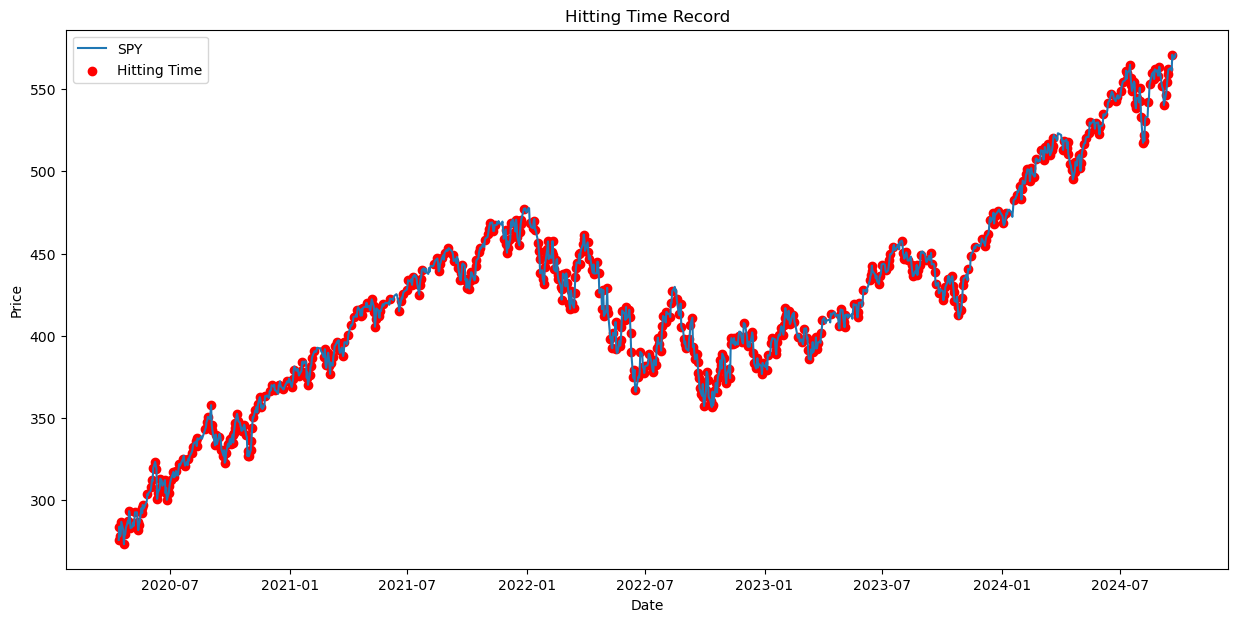

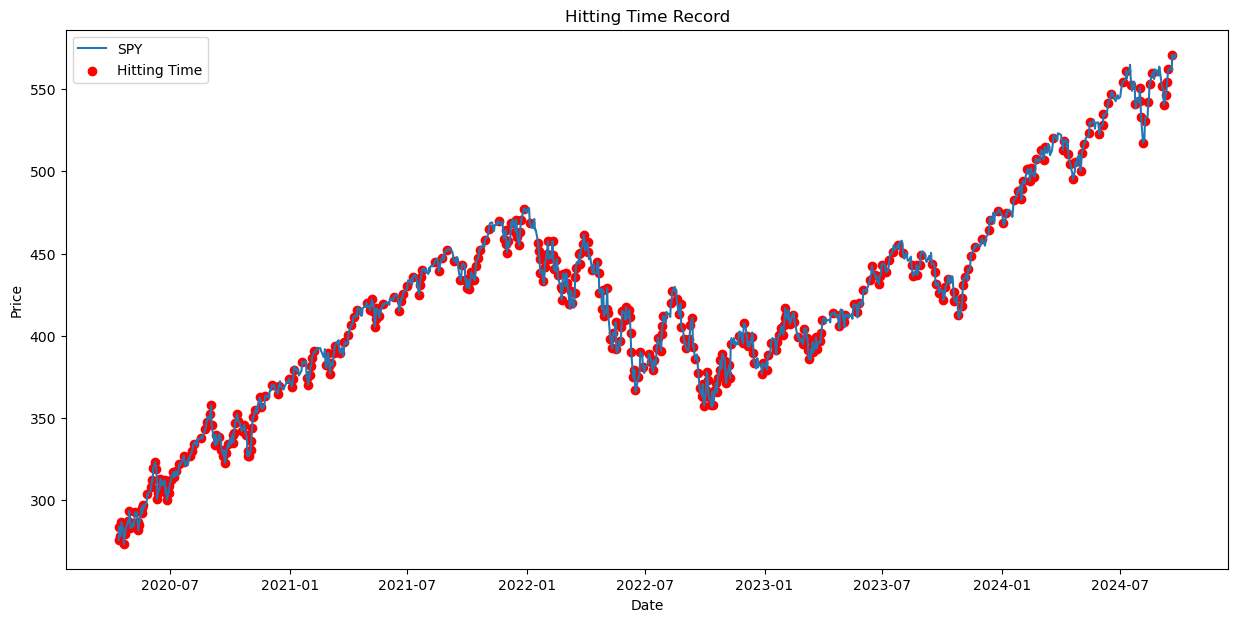

In [62]:
# Plot the hitting time record
plt.figure(figsize=(15, 7))
plt.plot(close_data.index, close_data["SPY"], label="SPY")
plt.scatter(hit_times, hit_values, color="red", label="Hitting Time")
plt.title("Hitting Time Record")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot the hitting time record
plt.figure(figsize=(15, 7))
plt.plot(close_data.index, close_data["SPY"], label="SPY")
plt.scatter(hit_times_adaptive, hit_values_adaptive, color="red", label="Hitting Time")
plt.title("Hitting Time Record")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

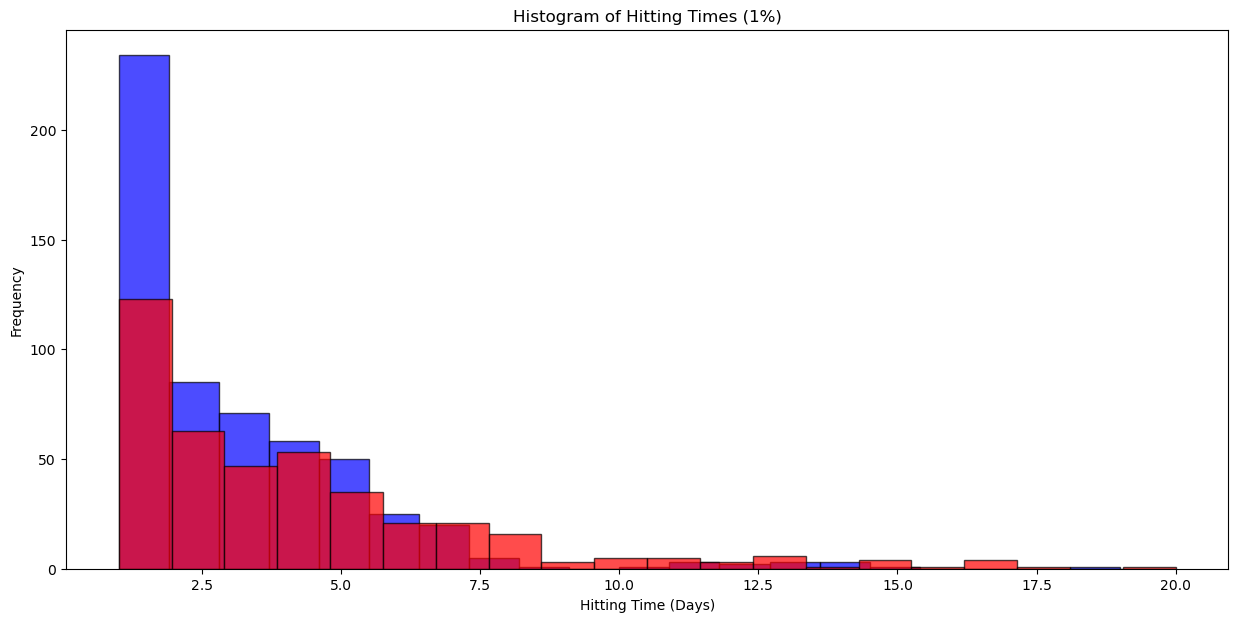

In [63]:
# Get difference between hitting times in days
hit_times_diff = np.diff(hit_times)
hit_time_diff_adaptive = np.diff(hit_times_adaptive)

# Convert Timedelta to days
hit_times_diff = [time.days for time in hit_times_diff]
hit_time_diff_adaptive = [time.days for time in hit_time_diff_adaptive]

# Plot histogram of hitting times
plt.figure(figsize=(15, 7))
plt.hist(hit_times_diff, bins=20, edgecolor="black", color="blue", alpha=0.7, label="Fixed Alpha")
plt.hist(hit_time_diff_adaptive, bins=20, edgecolor="black", color="red", alpha=0.7, label="Adaptive Alpha")
plt.title("Histogram of Hitting Times (1%)")
plt.xlabel("Hitting Time (Days)")
plt.ylabel("Frequency")
plt.show()


# Expected Length (Theoretical)

$$\mathbb{E}[L(\alpha, T)] \approx \frac{\mathbb{E}[X^2_T]}{\alpha^2}$$

Under the assumptions from previous formula of Bachelier Dynamic, $$dX_t =  \mu dt + \sigma dW_t,$$

we have 

$$\delta X_t = \mu \delta t + \sigma \sqrt{\delta_t} \phi_t,$$

where $\phi_t \sim \mathcal{N}(0, 1)$.

By turning into a regression problem to estimate the parameters $\mu$ and $\sigma$, we have

$$\delta x_t = \mu t + \epsilon_t$$

where $\epsilon_t ~ \mathcal{N}(0, \sigma^2 t)$. 


Therefore, 

$$var(\epsilon | X) = \sigma^2 V(X)$$

and 
$$V(X) = diag(X)$$


Option reserach direction: Find a better daily volatility correlation to remodel.

In [202]:
realized_expected_length = len(hit_times)*alphas["SPY"]**2

# Estimate the $\mu$ and $\sigma$ by Generalized Least Squares (WLS)

I know this could be very wrong. But I want to see how it goes.

In [203]:
delta_ts = [x.days for x in close_data["SPY"].index.to_series().diff()][1:]
delta_s = close_data["SPY"].diff().values[1:]

delta_s = delta_s / np.sqrt(delta_ts)
delta_ts = np.sqrt(delta_ts)

In [204]:
# Linear Regression
X = np.array(delta_ts).reshape(-1, 1)
Y = np.array(delta_s).reshape(-1, 1)

beta = np.linalg.inv(X.T @ X) @ X.T @ Y
sigma = np.sqrt(np.var(Y, ddof=1))

print(f"Estimated beta: {beta}")
print(f"Estimated sigma: {sigma}")

Estimated beta: [[0.1819323]]
Estimated sigma: 4.161351032319111


In [205]:
# Insanity Check

vol = sigma * np.sqrt(365) / close_data["SPY"].mean()

vix_data = yf.download("^VIX", interval="1d", group_by='ticker')
vix_data = vix_data["Close"]

print(f"Estimated Volatility: {vol}")
print(f"VIX: {vix_data.mean()/100}")

[*********************100%%**********************]  1 of 1 completed

Estimated Volatility: 0.1880707917866085
VIX: 0.19485750856998987


In [187]:
SPY_alpha = alphas["SPY"]

In [211]:
# Based on estimated beta and sigma
T = (close_data["SPY"].index[-1] - close_data["SPY"].index[0]).days
expected_XT = (close_data["SPY"].values[0] + beta[0] * T)[0] - close_data["SPY"].values[0]
print(f"Expected X_T: {expected_XT}")
print(f"Expected X_T^2: {expected_XT**2}")

expected_length_data = expected_XT**2 / SPY_alpha**2
print(f"Expected Length Based on Data: {expected_length_data}")
print(f"Realized Length: {realized_expected_length}")
print(f"Maximum Cap: {len(close_data) * SPY_alpha**2}")

Expected X_T: 295.6399841308594
Expected X_T^2: 87403.00021689478
Expected Length Based on Data: 11502.144662472627
Realized Length: 4285.747881711271
Maximum Cap: 8518.303857089246


We need to increase the frequency of data.